## **IMPORTS**

In [483]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import module.feature_selection as feature_selection
import module.feature_engineering as feature_engineering
import module.visualization as visualization
import module.classification_model as classification_model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import nbformat

In [484]:
%%capture
%run data_preprocessing.ipynb

## **LOGISTIC REGRESSION**

### **Feature Engineering**

In [485]:
from importlib import reload
reload(feature_selection)
reload(feature_engineering)
reload(visualization)
reload(classification_model)

<module 'module.classification_model' from 'c:\\Users\\arvin\\Documents\\Projects\\Default_Prediction_Project\\module\\classification_model.py'>

La **Regressione Logistica** è un modello di classificazione che può risentire indirettamente dell'**elevata dipersione dei dati**. Pertanto, prima di procedere all'allenamento del modello, è necessario effettuare alcune operazioni di **Feature Engineering**, al fine di aumentare il suo potere predittivo.

In [486]:
# Riepilogo statistico delle Features post-rimozione outliers
X_uncorr_clean.drop(['Bancarotta'], axis = 1).describe()

,Margine Lordo Operativo,Tasso di interesse netto dopo le tasse,Tasso di Spesa Operativa,Aliquota delle spese di ricerca e sviluppo,Tasso di flusso di cassa,Aliquota degli interessi sul debito,Aliquota fiscale (A),Valore Netto per Azione (A),Flusso di cassa per azione,Tasso di crescita dell'utile operativo,...,Debito totale/ Patrimonio netto totale,Livello di idoneità dei fondi a lungo termine (A),Crediti in sospeso/Patrimonio netto,Rotazione totale degli asset,Profitto operativo per persona,Debito a lungo termine su attività correnti,Riserve utili su attivo totale,Indice di Rotazione dell'Attivo Corrente,Grado di leva finanziaria (DFL),Capitale proprio/Passività
count,6372.000000,6372.000000,6.372000e+03,6.372000e+03,6372.000000,6.372000e+03,6372.000000,6372.000000,6372.000000,6372.000000,...,6372.000000,6372.000000,6372.000000,6372.000000,6372.000000,6.372000e+03,6372.000000,6.372000e+03,6372.000000,6372.000000
mean,0.607864,0.809354,2.031304e+09,1.983709e+09,0.466962,1.625879e+07,0.118013,0.188760,0.323246,0.848106,...,0.007403,0.008470,0.005789,0.142232,0.400197,5.323106e+07,0.936284,1.221141e+09,0.027092,0.044592
std,0.011305,0.000649,3.264304e+09,2.596430e+09,0.009649,1.076543e+08,0.139594,0.023804,0.010555,0.001226,...,0.011215,0.027793,0.001012,0.097455,0.029702,5.656096e+08,0.015124,2.851253e+09,0.002258,0.035899
min,0.559074,0.771507,0.000000e+00,0.000000e+00,0.419741,0.000000e+00,0.000000,0.113354,0.271911,0.817521,...,0.000129,0.004129,0.005366,0.001499,0.000000,0.000000e+00,0.858384,0.000000e+00,0.000000,0.009879
25%,0.600497,0.809314,1.549240e-04,1.298434e-04,0.461688,2.100210e-04,0.000000,0.174118,0.317960,0.847985,...,0.003142,0.005243,0.005366,0.079460,0.392596,0.000000e+00,0.931596,1.441299e-04,0.026791,0.024611
50%,0.605853,0.809375,2.650388e-04,5.940000e+08,0.465061,3.240324e-04,0.081385,0.184442,0.322487,0.848043,...,0.005589,0.005649,0.005366,0.121439,0.395904,2.212565e-03,0.937727,1.946929e-04,0.026812,0.033552
75%,0.613428,0.809464,4.272500e+09,3.500000e+09,0.470643,5.410541e-04,0.208422,0.198896,0.328358,0.848123,...,0.009148,0.006769,0.005788,0.178411,0.401529,9.215008e-03,0.944532,4.104844e-04,0.026921,0.050960
max,0.658578,0.822551,9.990000e+09,9.980000e+09,0.518511,9.900000e+08,1.000000,0.290885,0.376282,0.874452,...,0.520624,1.000000,0.030065,1.000000,1.000000,9.540000e+09,0.998858,1.000000e+10,0.070125,0.514908


Con **calculate_high_coeff_var()**, calcoliamo il **coefficiente di variazione (cv)** - che indica il **rapporto percentuale tra la deviazione standard e la media** - per ogni Features presente nel dataset post-rimozione degli outliers e selezioniamo solo quelle che hanno un valore **superiore al 50%**.

In [487]:
high_cv_features = feature_engineering.calculate_high_coeff_var(X_uncorr_clean.drop(['Bancarotta'], axis = 1))

Tasso di Spesa Operativa: 160.69%
Aliquota delle spese di ricerca e sviluppo: 130.88%
Aliquota degli interessi sul debito: 662.08%
Aliquota fiscale (A): 118.28%
Tasso crescita valore netto: 190.81%
Debito totale/ Patrimonio netto totale: 151.49%
Livello di idoneità dei fondi a lungo termine (A): 328.11%
Rotazione totale degli asset: 68.51%
Debito a lungo termine su attività correnti: 1062.47%
Indice di Rotazione dell'Attivo Corrente: 233.47%
Capitale proprio/Passività: 80.5%


Con **sqrt_transformation()**, trasformiamo le Features con cv superiore al 50% per ridurre la loro dispersione, utilizzando la **trasformazione della radice quadrata** (Square Root Trasformation)

In [488]:
log_reg_X_train, log_reg_X_test = feature_engineering.sqrt_transformation(X_train_smote, X_test, high_cv_features)

Osservando attentamente la **distribuzione numerica delle Features per classi del Target post-rimozione degli outliers**, notiamo che le seguenti Features contegono **valori molto grandi** rispetto alle altre:
- Tasso di Spesa Operativa: 1e10
- Aliquota delle spese di ricerca e sviluppo: 1e10
- Aliquota degli interessi sul debito: 1e9
- Debito a lungo termine su attività correnti: 1e10
- Indice di Rotazione dell'Attivo Corrente: 1e10

Per garantire la robustezza della Regressione Logistica, è necessario scalare la loro misura.

In [489]:
# Isolo le Features da trasformare
features_to_scale = [
    "Tasso di Spesa Operativa",
    "Aliquota delle spese di ricerca e sviluppo",
    "Aliquota degli interessi sul debito", 
    "Debito a lungo termine su attività correnti", 
    "Indice di Rotazione dell'Attivo Corrente"
    ]

Con **robust_scaler()**, scaliamo la misura delle Features menzionate sopra. **RobustScaler** è una tecnica che, oltre a uniformare la scala di misura, **preserva le proporzioni tra i valori**, senza modificare la loro distribuzione numerica, e **attenua l'effetto degli outliers** che la precedente operazione di pre-processing non è riusciuta a rimuovere.

In [490]:
log_reg_X_train, log_reg_X_test = feature_engineering.robust_scaler(log_reg_X_train, log_reg_X_test, features_to_scale)

### **Feature Selection**

Per aumentare ulteriormente le prestazioni della Regressione Logistica, possiamo effettuare un'operazione di **Feature Selection**, selezionando quelle che apportano **maggior significatività al modello**. Effettuiamo questa operazione in due modi:
- Con **SelectKBest (SKB)**, che seleziona le migliori k Features per il modello
- Con **Recursive Feature Elimination (RFE)**, che elimina le Features che non apportano significatività al modello

In [491]:
# Inizializzo il modello di Regressione Logistica
log_reg = LogisticRegression(
    solver = 'liblinear',
    penalty = 'l1',
    max_iter = 1000,
    random_state=42
    ) # solver, penalty e max_iter servono a far raggiungre la convergenza al modello

Con **calculate_accuracy()**, calcoliamo l'accuracy del modello per ogni k-esima Features

In [492]:
# Calcolo l'accuracy del modello per ogni k-esima Features con SKB
log_reg_skb_accuracies = feature_selection.calculate_accuracy('skb', log_reg, log_reg_X_train, y_train_smote)

100%|██████████| 22/22 [00:01<00:00, 15.44it/s]

Riserve utili su attivo totale: 0.77866473149492
Debito totale/ Patrimonio netto totale: 0.839622641509434
Capitale proprio/Passività: 0.8130261248185777
Valore Netto per Azione (A): 0.8130261248185777
Aliquota fiscale (A): 0.8054063860667634
Tasso di flusso di cassa: 0.8054063860667634
Margine Lordo Operativo: 0.8054063860667634
Flusso di cassa per azione: 0.8054063860667634
Profitto operativo per persona: 0.8054063860667634
Rotazione totale degli asset: 0.8323294629898405
Tasso crescita valore netto: 0.8323294629898405
Percentuale di reinvestimento del contante: 0.8323294629898405
Tasso di interesse netto dopo le tasse: 0.8323294629898405
Crediti in sospeso/Patrimonio netto: 0.8323294629898405
Tasso di crescita dell'utile operativo: 0.8323294629898405
Aliquota degli interessi sul debito: 0.7462626995645864
Debito a lungo termine su attività correnti: 0.7807692307692308
Aliquota delle spese di ricerca e sviluppo: 0.784579100145138
Livello di idoneità dei fondi a lungo termine (A): 0.7

In [493]:
# Calcolo l'accuracy del modello per ogni k-esima Features con RFE
log_reg_rfe_accuracies = feature_selection.calculate_accuracy('rfe', log_reg, log_reg_X_train, y_train_smote)

100%|██████████| 22/22 [00:07<00:00,  2.93it/s]

Debito totale/ Patrimonio netto totale: 0.805188679245283
Capitale proprio/Passività: 0.7996008708272859
Rotazione totale degli asset: 0.8148766328011611
Aliquota fiscale (A): 0.8323294629898405
Aliquota delle spese di ricerca e sviluppo: 0.832365747460087
Tasso di Spesa Operativa: 0.832365747460087
Aliquota degli interessi sul debito: 0.7368287373004354
Debito a lungo termine su attività correnti: 0.8035195936139333
Indice di Rotazione dell'Attivo Corrente: 0.8398766328011611
Grado di leva finanziaria (DFL): 0.818976777939042
Riserve utili su attivo totale: 0.8341799709724238
Valore Netto per Azione (A): 0.8246008708272858
Profitto operativo per persona: 0.8341436865021772
Crediti in sospeso/Patrimonio netto: 0.8209361393323658
Livello di idoneità dei fondi a lungo termine (A): 0.8361030478955007
Tasso di crescita dell'utile operativo: 0.8170174165457185
Flusso di cassa per azione: 0.8283744557329463
Percentuale di reinvestimento del contante: 0.8284833091436864
Tasso crescita valore 

Con **k_accuracy_lineplot**, visualizzaziamo con lineplot un confronto tra l'accuracy di SKB e l'accuracy di RFE sui **dati training**, mettendo in evidenza il **k ottimale**, ovvero il numero di Features selezionate dai rispettivi algoritmi di Feature Selection garantiscono un **corretto trade-off tra complessità e generalizzazione**:
- Il k ottimale con **SKB** è **10** per un accuracy pari a **0.8323** sui dati di training
- Il k ottimale con **RFE** è **9** per un accuracy pari a **0.8399** sui dati di training

Confrontando i risultati, l'**accuracy di RFE** è leggermente superiore a quello di SKB. Per giungere alle conclusioni, dobbiamo valutare l'impatto delle Features selezionate da entrambi gli algoritmi sui dati di **Test**.

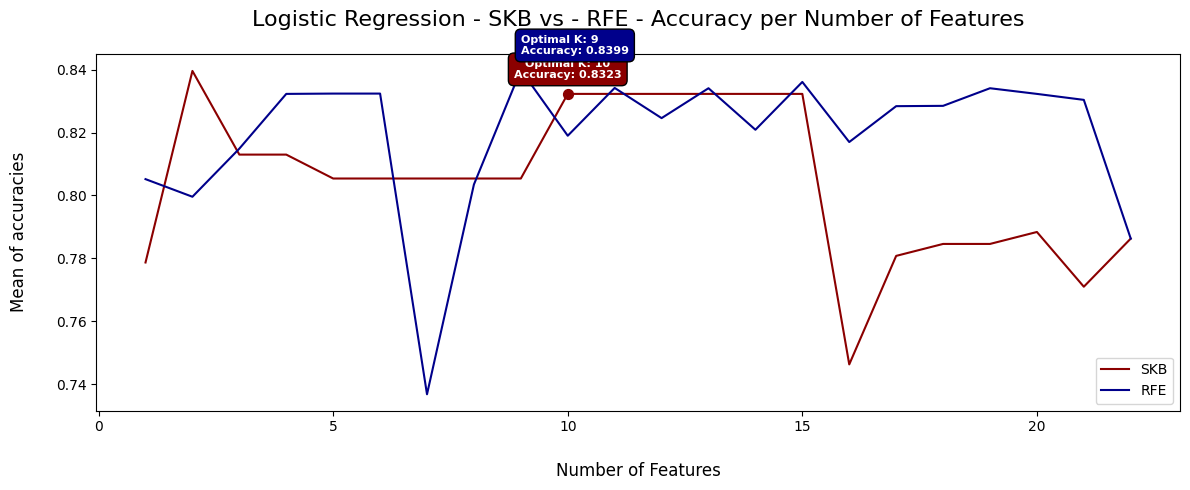

In [494]:
visualization.k_accuracy_lineplot('Logistic Regression', log_reg_skb_accuracies, log_reg_rfe_accuracies, 10, 9)

Con **features_selection()**, salviamo quali sono le Features più significative, per i rispettivi algoritmi di Feature Selection, con la Regressione Logistica

In [495]:
log_reg_skb_selected_features = feature_selection.feature_selection('skb', log_reg, log_reg_X_train, y_train_smote, 9)
log_reg_rfe_selected_features = feature_selection.feature_selection('rfe', log_reg, log_reg_X_train, y_train_smote, 10)

Con **features_selection_venn_diagram()**, visualizziamo quali sono le Features selezionate sia da SKB che da RFE, in modo da ottenere un'idea sulle Features più significative.

Le Features selezionate da entrambi gli algoritmi sono le seguenti:
- **Debito totale / Patrimonio netto toale**
- **Aliquota fiscale (A)**
- **Capitale proprio/Passività**

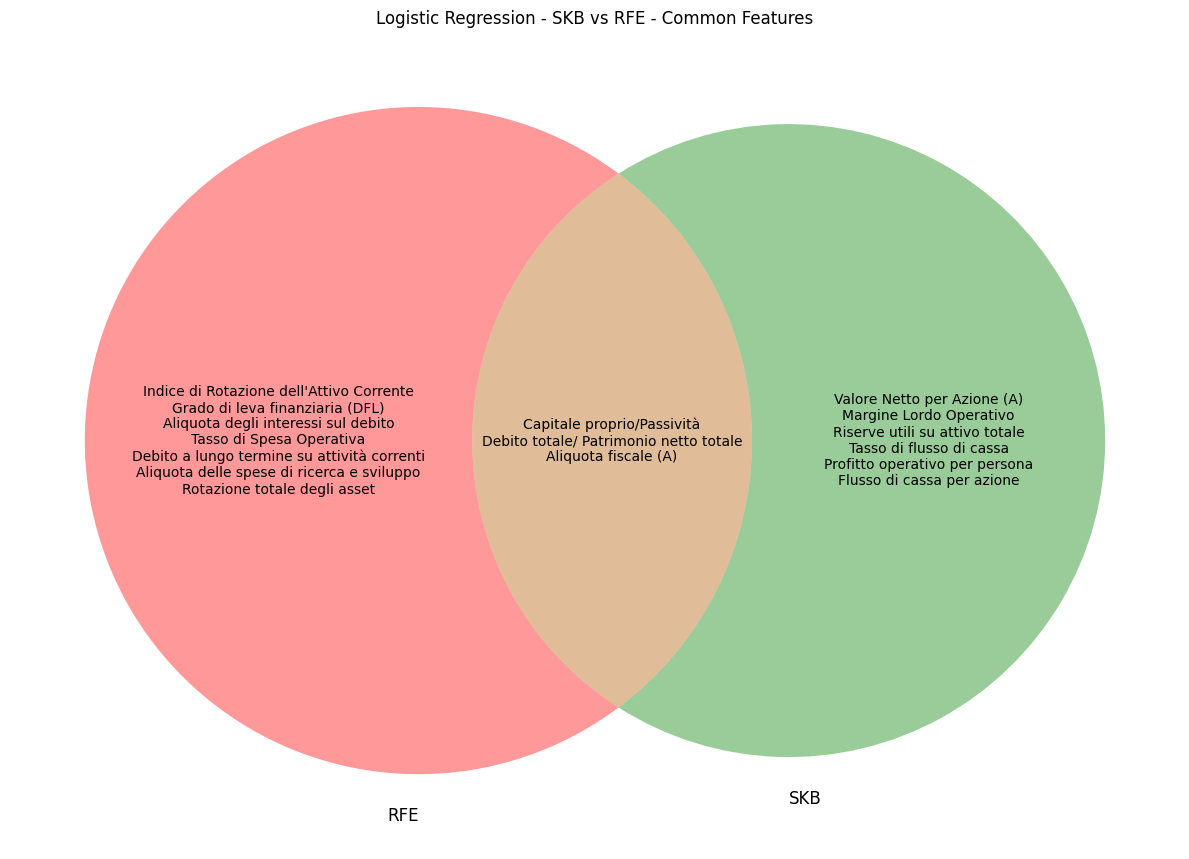

In [496]:
visualization.features_selection_venn_diagram('Logistic Regression', log_reg_skb_selected_features, log_reg_rfe_selected_features)

Con **model_accuracy()**, andiamo a calcolare l'accuracy della Regressione Logistica sui dati di **Test** con le Features selezionate da SKB ed RFE.

Dal risultato ottenuto, possiamo dire che le accuracy dei due algoritmi sono **piuttosto basse**:
- **SKB**: **0.51**
- **RFE**: **0.63**

In [497]:
# Calcolo il Test Accuracy della Regressione Logistica con le Features selezionate da SKB
log_reg_skb_y_pred, log_reg_skb_test_accuracy = classification_model.model_accuracy(log_reg, log_reg_skb_selected_features, X_test[log_reg_skb_selected_features.columns], y_train_smote, y_test)

Test Accuracy: 0.5135135135135135


In [498]:
# Calcolo il Test Accuracy della Regressione Logistica con le Features selezionate da RFE
log_reg_rfe_y_pred, log_reg_rfe_test_accuracy = classification_model.model_accuracy(log_reg, log_reg_rfe_selected_features, X_test[log_reg_rfe_selected_features.columns], y_train_smote, y_test)

Test Accuracy: 0.6351351351351351


In questo passaggio, andiamo a calcolare l'accuracy della Regressione Logistica sui dati di Test con **le sole Features selezionate da entrambi gli algoritmi** per verificare se il risultato che otteniamo è migliore.

Con **select_common_features()**, isoliamo le Features selezionate sia da SKB che RFE.

In [499]:
# Isolo le Features selezionate sia da SKB che RFE
log_reg_common_features_selected = feature_selection.select_common_features(log_reg_skb_selected_features, log_reg_rfe_selected_features)

Features comuni:
- Capitale proprio/Passività
- Debito totale/ Patrimonio netto totale
- Aliquota fiscale (A)


Con **model_accuracy()**, calcoliamo l'accuracy del modello sui dati di test con le Features selezionate sia da SKB che RFE.

L'accuracy che otteniamo è **significativamente migliore** (**0.81**).

In [500]:
log_reg_y_pred, log_reg_test_accuracy = classification_model.model_accuracy(log_reg, log_reg_X_train[log_reg_common_features_selected], log_reg_X_test[log_reg_common_features_selected], y_train_smote, y_test)

Test Accuracy: 0.8108108108108109


Con **confusion_matrix_heatmap()**, visualizziamo  tramite heatmap la **matrice di confusione** della Regressione Logistica.

I risultati sono i seguenti:
- **True Negatives** (**0**): il modello ha indovinato **27** compagnie che non vanno in bancarotta
- **False Positives** (**1**): il modello ha classificato **10** compagnie non in bancarotta come se andassero in bancarotta
- **False Negatives** (**0**): il modello ha classificato **4** compagnie in bancarotta come se non andassero in bancarotta
- **True Positives** (**1**): il modello ha indovinato **33** compagnie che vanno in bancarotta

In [501]:
# Calcolo la matrice di confusione sul Test Set
log_reg_conf_matrix = confusion_matrix(y_test, log_reg_y_pred)

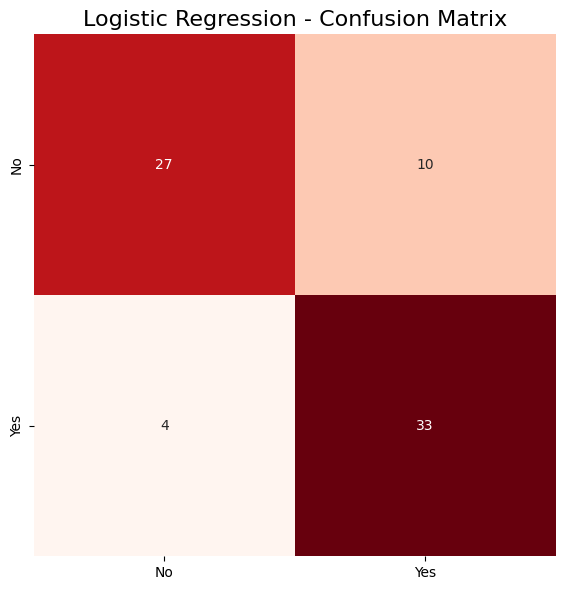

In [502]:
visualization.confusion_matrix_heatmap('Logistic Regression', log_reg_conf_matrix)

Con **conf_matrix_coefficients_analysis()**, analizziamo i **coefficienti** della matrice di confusione:
- **Precisione**: tra le compagnie classificate come in bancarotta, il modello riesce a indovinare correttamente il **76%** dei casi
- **Recall**: tra le compagnie effettivamente in bancarotta, il modello classifica correttamente l'**89%** dei casi
- **F1-score**: il modello ha un buon equilibrio tra Precisione e Recall, suggerendo che riesce a distinguere bene tra compagnie in bancarotta e non in bancarotta (**0.82**)
- **Specificità**: Tra le compagnie che effettivamente non vanno in bancarotta, il modello classifica correttamente quasi il **73%** dei casi

Essendo l'obiettivo di questa analisi quello di **prevedere le compagnie che vanno in bancarotta**, ovvero la **classe positiva del Target**, per cui **Recall** e **F1-score** sono le metriche principali da considerare, la Regressione Logistica fornisce degli **ottimi risultati**.

In [503]:
# Calcolo i coefficienti della Matrice di Confusione per la Regressione Logistica con SKB
log_reg_precision, log_reg_recall, log_reg_f1, log_reg_tn, log_reg_fp, log_reg_fn, log_reg_tp, log_reg_specificity = classification_model.conf_matrix_coefficients_analysis(y_test, log_reg_y_pred, log_reg_conf_matrix)

Precisione: 0.7674418604651163
Recall: 0.8918918918918919
F1-score: 0.825
Specificità: 0.7297297297297297


Con **conf_matrix_coefficients_to_df()**, creiamo un **dataframe per le metriche della matrice di confusione**. Questo dataframe, ci torna utile nel passaggio successivo per costruire una **visualizzazione grafica**.

In [504]:
log_reg_conf_matrix_coefficients_df = classification_model.conf_matrix_coefficients_to_df(log_reg_precision, log_reg_recall, log_reg_f1, log_reg_specificity)

Con **conf_matrix_coefficients_barplot**, visualizziamo tramite barplot le metriche della matrice di confusione.

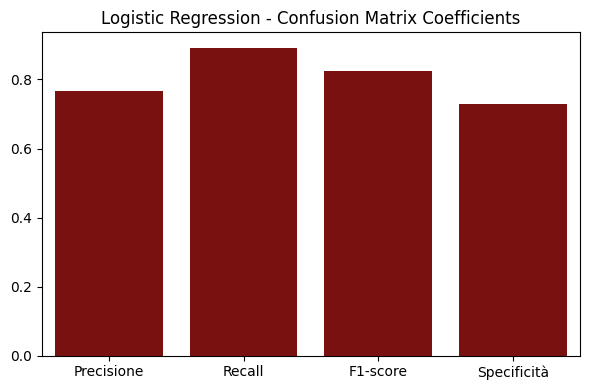

In [505]:
visualization.conf_matrix_coefficients_barplot2('Logistic Regression', log_reg_conf_matrix_coefficients_df)

Con **model_auc_roc_gini()**, calcoliamo l'**Area Under the Receiver Operating Characteristic (AUC-ROC)** e l'**Indice di Gini** della Regressione Logistica.

La **AUC-ROC** misura la **capacità di un modello di distinguere correttamente tra le classi del Target**. Viene calcolato tramite la **curva ROC**, che traccia il **tasso di veri positivi** (**TPR**) contro il **tasso di falsi positivi** (**FPR**) a vari livelli di soglia. L'**AUC** è **l'area sotto questa curva**, con un valore **compreso tra 0 e 1**, dove un AUC **vicino a 1** indica una **buona capacità di discriminazione** del modello.

L'**Indice di Gini** è una **misura di impurità o disomogeneità** che, nell'ambito della classificazione, viene usato principalmente per **valutare le performance del modello**. È una misura strettamente legata alla **curva ROC**. Infatti, la sua formula è la seguente: **Gini = 2×AUC−1**.

Dal risultato, possiamo affermare che la Regressione Logistica ha anche un'**ottima capacità di distinzione** tra compagnie in bancarotta e non.

In [506]:
log_reg_auc, log_reg_gini = classification_model.model_auc_roc_gini('Logistic Regression', log_reg_y_pred, y_test)

Logistic Regression - AUC-ROC: 0.8108108108108109
Logistic Regression - Indice di Gini: 0.6216216216216217


Con **roc_curve_plot()**, visualizziamo graficamente la **curva ROC** della Regressione Logistica.

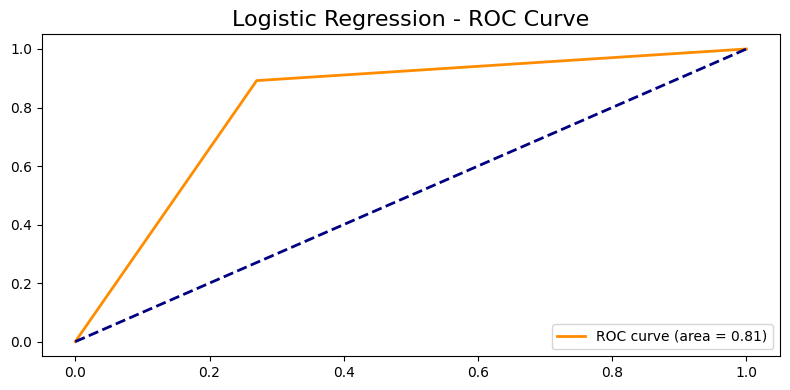

In [507]:
visualization.roc_curve_plot2('Logistic Regression', y_test, log_reg_y_pred, log_reg_auc)

### **Logistic Regression Coefficient Analysis**

Con **log_reg_coefficients_summary()**, andiamo a visualizzare un riepilogo dei **coefficienti** della Regressione Logistica:
- **LL-Null**: -rappresenta la **Log-Likelihood** del ***modello nullo**, ossia un modello che non fa alcuna previsione basata su variabili predittive. Il suo valore serve come punto di riferimento per determinare **quanto un modello con variabili predittive migliori rispetto a un modello che non ha nessuna informazione**
- **Log-Likelihood**: rappresenta la **Log-Likelihood** del modello con le variabili predittive, che ci dice quanto bene il modello si adatta ai dati osservati
- **Pseudo R-squared**: misura la **quantità di varianza spiegata** dal modello, che è l'equivalente dell'**R²** nella Regressione Lineare. Il **valore massimo** di Pseudo R-squared è **compreso tra 0 e 1**, con valori più alti che indicano una migliore capacità predittiva.
- **LLR p-value**: è un **test statistico** che **confronta il modello con variabili predittive con il modello nullo** (**senza predittori**). In particolare, questo valore indica se l'aggiunta delle variabili predittive ha migliorato significativamente il modello rispetto al modello nullo.

Dal riepilogo che abbiamo ottenuto, possiamo affermare che:
- Il modello spiega **circa il 42.61% della varianza** nei dati  (**Pseudo R-square**)
- Abbiamo un **incremento significativo** nella log-likelihood (**differenza tra LL-Null e Log-Likelihood**), indicando che il modello con le variabili predittive è notevolmente migliore di un modello nullo. La differenza tra i due è notevole ed è pari a **154.77** (**363.21 - 208.44**). Questo suggerisce che l'**aggiunta delle variabili predittive migliora notevolmente il modello**
- **Il modello è significativamente migliore del modello nullo**, poichè il **p-value** che abbiamo ottenuto (**8.585e-67**) è talmente piccolo che possiamo **rifiutare l'ipotesi nulla** 

Entrando nel dettaglio e analizzando le varie Features, escludendo la costante:
- **Coefficiente** **Debito totale / Patrimonio netto totale** ha un **coefficiente positivo** (**41.6695**), indicando che un suo incremento **aumenta la probabilità di bancarotta**; mentre, al contrario, **Aliquota fiscale (A)** e **Capitale proprio/Passività**, avendo un **coefficiente negativo** (**-2.5739** e **-10.3048**), **riducono la probabilità di bancarotta**
- **P-value**: tutte e tre le Features sono significative poiché hanno un **P-value inferiore a 0.5** (**0** - **0** - **0.294**)
- **Intervallo di Confidenza**: delle tre Features, solo **Capitale proprio/Passività** ha un **Intervallo di Confidenza che include lo zero**, suggerendo che **pecca di significatività** poiché non possiamo affermare con certezza che l'effetto della variabile sia diverso da zero

Per l'analisi dell'**Errore Standard**, conviene considerare il **T-Value**, ovvero il **rapporto tra Coefficiente ed Errore Standard**, che viene approfondito nel passaggio successivo. Generalmente, un **T-value accettabile** deve essere **maggiore di 2**.

In [508]:
log_reg_coefficients_summary = classification_model.log_reg_coefficients_summary(log_reg_X_train[log_reg_common_features_selected], y_train_smote)

Optimization terminated successfully.
         Current function value: 0.397788
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             Bancarotta   No. Observations:                  524
Model:                          Logit   Df Residuals:                      520
Method:                           MLE   Df Model:                            3
Date:                Sun, 29 Dec 2024   Pseudo R-squ.:                  0.4261
Time:                        19:59:58   Log-Likelihood:                -208.44
converged:                       True   LL-Null:                       -363.21
Covariance Type:            nonrobust   LLR p-value:                 8.585e-67
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                    -30.8918   

Con **log_reg_coefficients_df()**, creiamo un dataframe che riporta per ogni Features del modello: **coefficiente**, **P-value**, **T-value** e **Intervallo di Confidenza**. Il dataframe creato ci torna utile nel passaggio successivo, in cui andiamo a costruire una visualizzazione grafica.

In [509]:
log_reg_coefficients_df = classification_model.log_reg_coefficients_df(log_reg_coefficients_summary)

Con **log_reg_coefficients_barplot()**, visualizziamo tramite barplot i coefficienti della Regressione Logistica.

Graficamente, abbiamo la conferma di quanto affermato sopra. Considerando il **T-value**, **Capitale Proprio / Passività** conferma di essere la Features **meno significativa**, suggerendo anche la possibilità di essere rimossa.

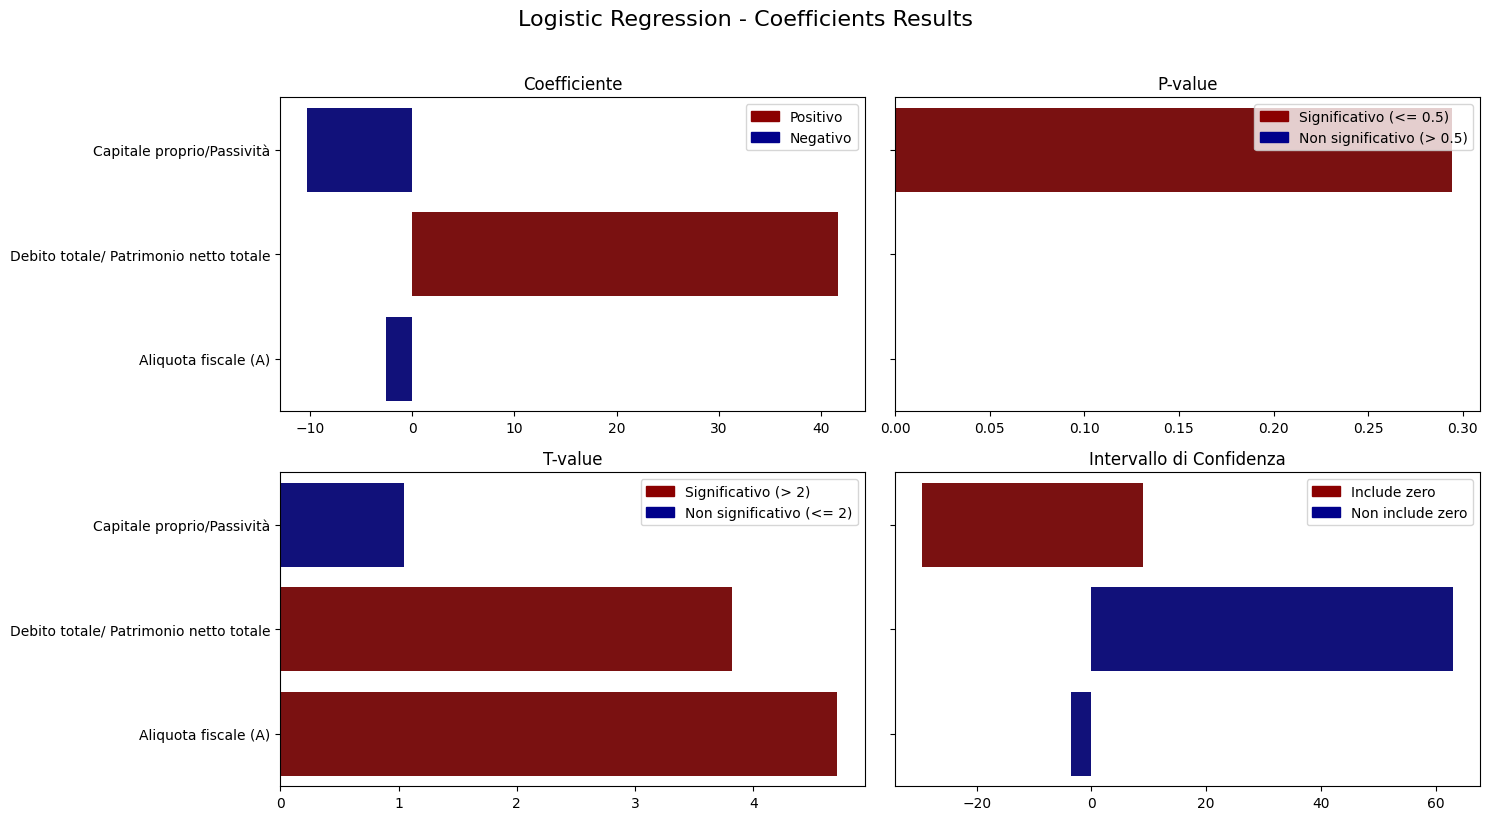

In [521]:
visualization.log_reg_coefficients_barplot(log_reg_coefficients_df)

Proviamo a ricalcolare il test accuracy della Regressione Logistica rimuovendo tra le Features **Capitale proprio/Passività**

In [511]:
# Rimuovo Capitale proprio/Passività tra le Features
log_reg_features_selected = log_reg_common_features_selected[1:3]

Rimuovendo **Capitale proprio/Passività**, il test accuracy del modello aumenta leggermente (**0.82** vs **0.81**).

In [512]:
# Calcolo nuovamente il Test accuracy
log_reg_y_pred2, log_reg_test_accuracy2 = classification_model.model_accuracy(log_reg, log_reg_X_train[log_reg_features_selected], log_reg_X_test[log_reg_features_selected], y_train_smote, y_test)

Test Accuracy: 0.8243243243243243


Procediamo calcolando e visualizzando la nuova **matrice di confusione**.

In [513]:
# Calcolo la nuova matrice di confusione
log_reg_conf_matrix2 = confusion_matrix(y_test, log_reg_y_pred2)

Facendo un confronto con la matrice di confusione precedente:
- **True Negatives** (**0**): rimangono uguali (**27**)
- **False Positives** (**1**): rimangono uguali (**10**)
- **False Negatives** (**0**): diminuiscono da **4** a **3**, il che è positivo
- **True Positives** (**1**): aumentano da **33** a **34**, il che è positivo


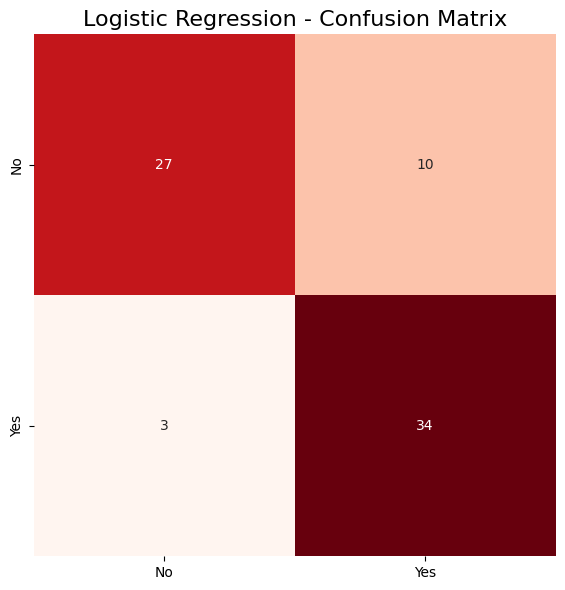

In [514]:
# Visualizzo la nuova matrice di confusione
visualization.confusion_matrix_heatmap('Logistic Regression', log_reg_conf_matrix2)

A questo punto, ricalcoliamo **Precision**, **Recall**, **F1-score** e **Specificity**, e li visualizziamo graficamente.

Facendo un confronto con le metriche precedenti:
- **Precisione**: aumenta da **0.76** a **0.77**
- **Recall**: aumenta da **0.89** a **0.91**
- **F1-score**: aumenta da **0.82** a **0.83**
- **Specificità**: rimane invariato (**0.72**)

Ricordando che l'obiettivo dell'analisi è quello di **prevede le compagnie che vanno in bancarotta**, l'aumento di **Recall** e **F1-score** sono positivi.

In [515]:
# Calcolo i coefficienti della Matrice di Confusione per la Regressione Logistica con SKB
log_reg_precision2, log_reg_recall2, log_reg_f12, log_reg_tn2, log_reg_fp2, log_reg_fn2, log_reg_tp2, log_reg_specificity2 = classification_model.conf_matrix_coefficients_analysis(y_test, log_reg_y_pred2, log_reg_conf_matrix2)

Precisione: 0.7727272727272727
Recall: 0.918918918918919
F1-score: 0.8395061728395061
Specificità: 0.7297297297297297


In [516]:
# Creo un dataframe per le nuove metriche della matrice di confusione
log_reg_conf_matrix_coefficients_df2 = classification_model.conf_matrix_coefficients_to_df(log_reg_precision2, log_reg_recall2, log_reg_f12, log_reg_specificity2)

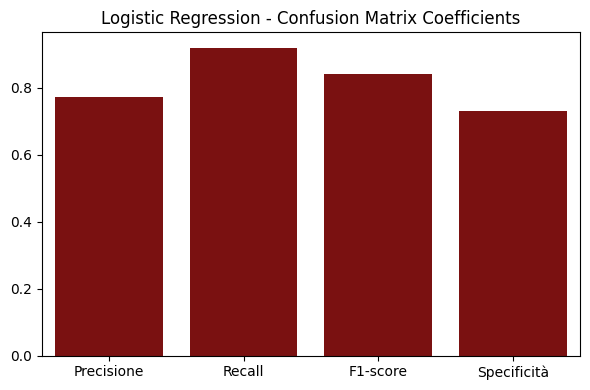

In [517]:
# Visualizzo graficamente con barplot le nuove metriche
visualization.conf_matrix_coefficients_barplot2('Logistic Regression', log_reg_conf_matrix_coefficients_df2)

Per concludere, calcoliamo nuovamente **AUC-ROC** e **Indice di Gini**, e visualizzamo graficamente la **curva ROC**.

Facendo un confronto con il caso precedente:
- **AUC-ROC**: aumenta da **0.81** a **0.82**
- **Indice di Gini**: aumenta da **0.62** a **0.64**

Pertanto, possiamo confermare definitivamente che il modello senza **Capitale proprio/Passività** sia migliore.

In [518]:
# Calcolo nuovamente AUC-ROC e Indice di Gini
log_reg_auc2, log_reg_gini2 = classification_model.model_auc_roc_gini('Logistic Regression', log_reg_y_pred2, y_test)

Logistic Regression - AUC-ROC: 0.8243243243243243
Logistic Regression - Indice di Gini: 0.6486486486486487


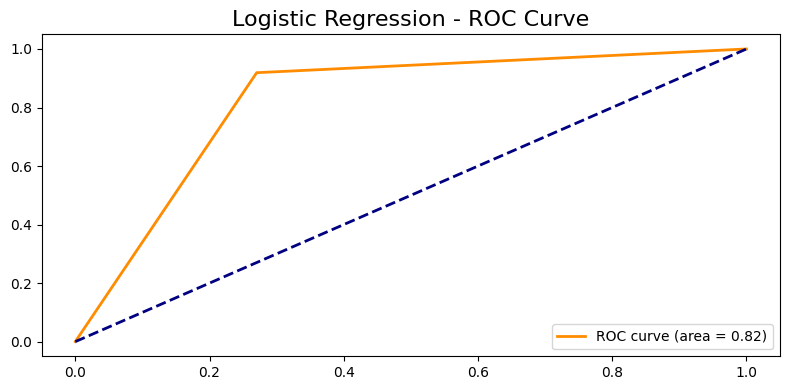

In [519]:
# Visualizzo graficamente la nuova curva ROC
visualization.roc_curve_plot2('Logistic Regression', y_test, log_reg_y_pred2, log_reg_auc2)